In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from helpers import *

In [68]:
#data_folder = "C:/Users/bapti/ADA2024-projet/MovieSummaries/"
#data_folder = "C:/Users/cricl/PROJADA/MovieSummaries/MovieSummaries/"
data_folder = "C:/Users/locar/Desktop/Project ADA/MovieSummaries/"
#data_folder = "C:/Users/thoma/Documents/ADA_Projet_Data/MovieSummaries/"
########### A CHANGER LE PATH DU FOLDER ##################

In [69]:
try:
    from names_dataset import NameDataset, NameWrapper
except Exception as e:
    %pip install names-dataset
    from names_dataset import NameDataset, NameWrapper

# 1.Datasets creation

## 1.1 Import the data

In [70]:
movie_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", # Freebase ID:name tuples
    "Movie_countries", # Freebase ID:name tuples
    "Movie_genres"] # Freebase ID:name tuples

char_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_release_date",
    "Character_name",
    "Actor_date_of_birth",
    "Actor_gender",
    "Actor_height_m", # in meters
    "Actor_ethnicity", # Freebase ID
    "Actor_name",
    "Actor_age_at_movie_release",
    "Freebase_character_actor_map_ID",
    "Freebase_character_ID",
    "Freebase_actor_ID"]

In [71]:
df_movie = pd.read_csv(data_folder+'movie.metadata.tsv', delimiter = '\t', names = movie_col_name, header = None)
df_char = pd.read_csv(data_folder+'character.metadata.tsv', delimiter = '\t', names = char_col_name, header = None)

In [72]:
print("Shape of the movie dataset:", df_movie.shape)
print("Shape of the character dataset:", df_char.shape)

Shape of the movie dataset: (81741, 9)
Shape of the character dataset: (450669, 13)


## 1.2 Merging the datasets

The idea is to have all the characterisitics in one single dataset

In [73]:
# We check if the two datasets have identical columns
common_col = set(movie_col_name) & set(char_col_name)
print(f"We have {len(common_col)} common columns")

We have 3 common columns


In [74]:
#We merge the two datasets
merged_df = pd.merge(df_movie, df_char, on=['Wikipedia_movie_ID', 'Freebase_movie_ID'], how='inner', suffixes=('', '_y'))
merged_df['Movie_release_date'] = merged_df['Movie_release_date'].combine_first(merged_df['Movie_release_date_y'])
merged_df.drop('Movie_release_date_y', axis =1, inplace = True, errors='ignore')
merged_df = merged_df.drop(columns=['Wikipedia_movie_ID','Freebase_movie_ID','Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])

print("Shape of the merged dataset: ", merged_df.shape)

Shape of the merged dataset:  (450669, 14)


In [75]:
merged_df.head(3)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0


## 1.3 Managing data types

As we want to work with the dates, the ages, the genders we have to make sure that the data types are the good ones. We also want to transform some variables, for example the movie_genres wich are dict where the key is the genre ID and we don't want to keep it.
We also want to convert the dates to datetime to make some calculus with later.

In [76]:
# We convert the chains into dicts
merged_df['Movie_languages'] = merged_df['Movie_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df['Movie_countries'] = merged_df['Movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df['Movie_genres'] = merged_df['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# We create a column for the extracted first item in the list and we assume is the principal one
merged_df['Main_genre'] = merged_df['Movie_genres'].apply(extract_first_genre)
merged_df['Main_country'] = merged_df['Movie_countries'].apply(extract_first_genre)

# We replace the language, countries and genre columns by list of values
merged_df['Movie_languages'] = merged_df['Movie_languages'].apply(extract_all_genres)
merged_df['Movie_countries'] = merged_df['Movie_countries'].apply(extract_all_genres)
merged_df['Movie_genres'] = merged_df['Movie_genres'].apply(extract_all_genres)
merged_df['Movie_languages'] = merged_df['Movie_languages'].apply(lambda x: [y.replace(" Language","").replace(" languages","") for y in x])

#Convert the dates to datetime format for later calculations
merged_df['Movie_release_date'] = pd.to_datetime(merged_df['Movie_release_date'], errors='coerce').dt.normalize()
merged_df['Actor_date_of_birth'] = pd.to_datetime(merged_df['Actor_date_of_birth'], errors='coerce').dt.normalize()

In [77]:
merged_df.head(3)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Thriller,United States of America
1,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America
2,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Thriller,United States of America


Here is now our dataset with the desired data types for each of our interest column.

# 2.Study the raw data

In [78]:
merged_df.describe()

,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,273872,1.010280e+05,4.001990e+05,329887,154824.000000,292556.000000
mean,1986-03-21 01:35:51.124612992,6.940705e+07,1.288516e+02,1943-05-29 11:41:52.427588736,1.788893,37.788523
min,1894-11-17 00:00:00,1.000000e+04,0.000000e+00,1796-09-20 00:00:00,0.610000,-7896.000000
25%,1971-05-26 00:00:00,3.600000e+06,8.800000e+01,1922-09-01 00:00:00,1.676400,28.000000
50%,1997-04-04 00:00:00,1.784087e+07,9.700000e+01,1948-02-25 00:00:00,1.750000,36.000000
75%,2006-09-05 00:00:00,6.684503e+07,1.120000e+02,1966-07-11 00:00:00,1.830000,47.000000
max,2016-06-08 00:00:00,2.782275e+09,1.079281e+06,2011-09-02 00:00:00,510.000000,103.000000
std,NaN,1.469544e+08,5.394664e+03,NaN,4.379940,20.587870


We can observe some interesting points which seems impossible:
- Some actors have negative ages
- Some actors measure up to $510$ m high
- Some movies have a null or a million minutes runtime($\approx 1.9$ years)

# 3.Treating missing values and incoherent values

## 3.1 Filtering incoherent values

We choose to replace the impossible values by NaN because later we'll try to reconstruct the dataset

- We keep the actor ages superior or equal to 0 because some actors (babies) may be less than 1 year old so it will appear as 0.

- We keep the actor heights less than the tallest person on earth which is 2.72m.

- We keep the movie runtime superior to 1min because it is not a movie in this case. We also impose a maximum value of 51'420 minutes because according to wikipedia, the longest movie duration is $\approx 35$ days.

- We keep the movie release date superior to the actor date of birth because we don't want to have negative ages after calculations.

In [79]:
#Replace negative ages by NaN
merged_df['Actor_age_at_movie_release'] = merged_df.query('Actor_age_at_movie_release >= 0')['Actor_age_at_movie_release']

#Replace heights superior to 3 meters by NaN
merged_df['Actor_height_m'] = merged_df.query('Actor_height_m < 2.72')['Actor_height_m']

#Replace null movie runtime by NaN
merged_df['Movie_runtime'] = merged_df.query('Movie_runtime > 1')['Movie_runtime']

#Replace movie runtime superior to 35 days to NaN
merged_df['Movie_runtime'] = merged_df.query('Movie_runtime < 51420')['Movie_runtime']

#Check if there is some movies are released after the actor birth and replace both by NaN
merged_df[['Movie_release_date', 'Actor_date_of_birth']] = merged_df.query('Movie_release_date > Actor_date_of_birth')[['Movie_release_date', 'Actor_date_of_birth']]

merged_df.describe()

,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,205197,1.010280e+05,400163.000000,205197,154809.000000,292175.000000
mean,1983-10-11 09:52:52.309536832,6.940705e+07,101.892150,1944-05-26 05:02:33.107501568,1.748177,37.890901
min,1894-11-17 00:00:00,1.000000e+04,1.250000,1796-09-20 00:00:00,0.610000,0.000000
25%,1965-04-21 00:00:00,3.600000e+06,88.000000,1923-03-24 00:00:00,1.676400,28.000000
50%,1994-08-29 00:00:00,1.784087e+07,97.000000,1950-03-26 00:00:00,1.750000,36.000000
75%,2005-09-23 00:00:00,6.684503e+07,112.000000,1968-03-06 00:00:00,1.830000,47.000000
max,2016-06-08 00:00:00,2.782275e+09,9360.000000,2008-10-29 00:00:00,2.356000,103.000000
std,NaN,1.469544e+08,42.953552,NaN,0.106249,14.085909


We can now oberve that we have no more impossible values for the movie runtime, the actor's height and the actor's age

## 3.2 Missing values before data reconstruction

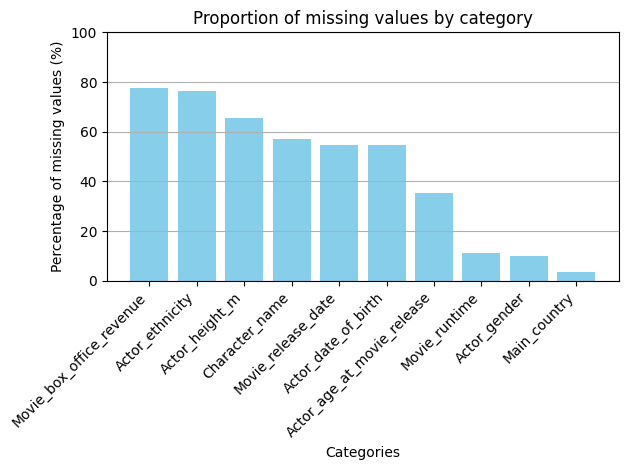

In [80]:
proportion_of_null = merged_df.isnull().mean()*100
proportion_of_null = proportion_of_null[proportion_of_null>1] #only missing at least 1% of value
proportion_of_null = proportion_of_null.sort_values(ascending=False)

plt.bar(proportion_of_null.index, proportion_of_null.values, color='skyblue')
plt.title('Proportion of missing values by category')
plt.xlabel('Categories')
plt.ylabel('Percentage of missing values (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,100)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

We can observe that we have missing values for the date of release($\approx 55 \%$), the actor age($\approx 35 \%$) and the actor gender($\approx 10 \%$)

The dates of release cannot be reconstructed by we can try to recreate the data for the gender using an additional dataset and the age using the date of release and the actor's date of birth.

## 3.3 Dataset reconstruction
As seen previously, some of our our interest variables have missing values. We want to try to reconstruct our dataset to have a more representative sample.
- The missing genders will be deduced from an additional dataset that associates first name with a gender
- After this reconstruction, if there are any missing genders, they will be replaced by "Unknown"
- The missing actors' ages will be calculated from their date of birth and the movie release date

In [81]:
#We initialize the database
#nd = NameDataset()

In [82]:
#We count the number of missing values before reconstruction
missing_genders_BR = merged_df['Actor_gender'].isnull().sum()

In [83]:
#We reconstruct the actor gender based on his/her first name using the get_gender() function
merged_df.loc[(merged_df['Actor_gender'].isnull()) & (merged_df['Actor_name'].notnull()), 'Actor_gender'] = merged_df.loc[(merged_df['Actor_gender'].isnull()) & (merged_df['Actor_name'].notnull()), 'Actor_name'].apply(get_gender)
print(f"We reconstructed {missing_genders_BR - merged_df['Actor_gender'].isnull().sum()} over {missing_genders_BR} missing genders")

#All the actors we weren't able to reconstruct gender, we replace it by 'Unknown'
merged_df.loc[merged_df['Actor_gender'].isnull(),'Actor_gender'] = 'Unknown'

We reconstructed 41292 over 45609 missing genders


In [84]:
merged_df.loc[merged_df['Actor_gender'] == 'Unknown'].head(3)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country
139,Road to Life,NaT,NaN,104.0,[Russian],[Soviet Union],[Drama],NaN,NaT,Unknown,NaN,NaN,Bozhak Besprizornykh,NaN,Drama,Soviet Union
140,Road to Life,NaT,NaN,104.0,[Russian],[Soviet Union],[Drama],NaN,NaT,Unknown,NaN,NaN,Tsifan Kyriya,NaN,Drama,Soviet Union
164,Baby Boy,NaT,29381649.0,123.0,[English],[United States of America],"[Crime Fiction, Drama, Coming of age]",Já Toi,NaT,Unknown,NaN,NaN,Jamaica Carter,NaN,Crime Fiction,United States of America


We can suppose that our name dataset do not know the last names or maybe they are too ambiguous so we cannot affirm it is a male or a female.

In [85]:
#We search for the number of missing actors' ages
#We also check if the actor's age can be calculated knowing the movie release date and the actor's date of birth
age_mask = (merged_df['Actor_age_at_movie_release'].isnull()) & (merged_df['Movie_release_date'].notnull()) & (merged_df['Actor_date_of_birth'].notnull())
count_age_incomplete  = merged_df[age_mask].shape[0]
print(f"We have {count_age_incomplete} missing actors' ages that can be calculated")

We have 21031 missing actors' ages that can be calculated


In [86]:
#We compute the actors' ages
merged_df.loc[age_mask,'Actor_age_at_movie_release'] = (merged_df['Movie_release_date'] - merged_df['Actor_date_of_birth']).dt.days // 365
#We replace the ages superior to 115 by NaN
merged_df['Actor_age_at_movie_release'] = merged_df.query('Actor_age_at_movie_release < 115')['Actor_age_at_movie_release']

#Now, we only want to keep the years of the release date
merged_df['Movie_release_date'] = merged_df['Movie_release_date'].dt.year

## 3.4 Analysis of the missing values after data reconstruction

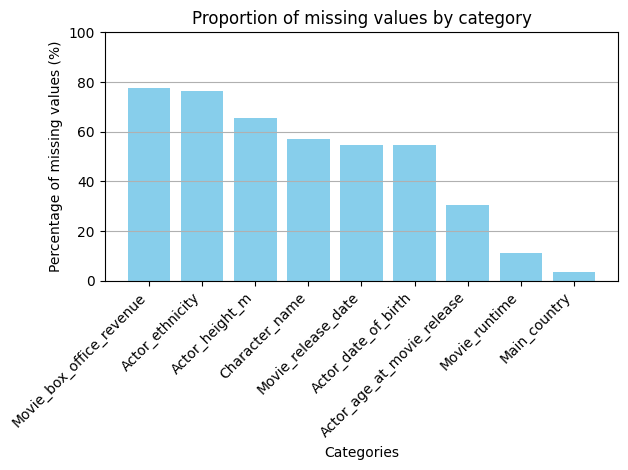

In [87]:
proportion_of_null = merged_df.isnull().mean()*100
proportion_of_null = proportion_of_null[proportion_of_null>1] #only missing at least 1% of value
proportion_of_null = proportion_of_null.sort_values(ascending=False)

plt.bar(proportion_of_null.index, proportion_of_null.values, color='skyblue')
plt.title('Proportion of missing values by category')
plt.xlabel('Categories')
plt.ylabel('Percentage of missing values (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylim(0,100)
plt.grid(axis='y')
plt.show()

1. **`Movie_release_date`**  
   - There are still many missing values ($\approx 55 \%$), and this appears to be a critical field for historical analyses.
   - Ensure that movies without release dates are filtered out for chronological analyses. Time-trend analyses should be limited to movies with valid and existing dates.
   - **Action:** Drop the NaN values for the movie release date

2. **`Movie_box_office_revenue`**  
   - It has the highest proportion of missing values ($\approx 78 \%$), it would really impact our final dataset if we decide to drop them
   - **Action:** Create a subdataset containing only complete entries for this column.

3. **`Actor_age_at_movie_release`**  
   - We decreased of approximatively $5 \%$ our missing values. As this column is very useful for our age-based analysis we want to get rid of the missing values.
   - **Action:** Drop the NaN values for the actor age

4. **`Actor_gender`**  
   - No missing values remain in this column!
   - Missing data was replaced with "Unknown" to avoid having a 100% proportion of male/female in a movie for example
   - **Action:** Nothing

5. **`Main_genre`**
   - We have less than $1 \%$ missing value for the dataset
   - **Action:** Drop the NaN values for the movie main genre

6. **`Main_country`**
   - We have a few missing values ($\approx 5 \%$)
   - **Action:** Drop the NaN values for the movie main country
  
7. **`Actor_ethnicity`**, **`Actor_height_m`**, **`Movie_runtime`**, **`Character_name`**, **`Freebase_character_ID`** and **`Actor_date_of_birth`**
   - These fields are not interesting for our project, the proportion of missing values is then, not important and dropping the null values will reduce unnecessarily our dataset size.
   - **Action:** Nothing

## 3.5 NaN treatment

After the missing values analysis, we choose to drop the NaN values for our interest variables :
- Movie release date
- Age
- Country
- Main Genre

In [88]:
col2drop = ['Character_name','Actor_date_of_birth']
small_df = merged_df.copy().drop(columns=col2drop).dropna()
big_df = merged_df.dropna(subset=['Movie_release_date', 'Main_country', 'Main_genre', 'Actor_age_at_movie_release']).drop(columns=col2drop)

print("Shape of the merged dataset after droping NaN in interest columns: ", big_df.shape)
print("Shape of the merged dataset after droping NaN in all columns: ", small_df.shape)

Shape of the merged dataset after droping NaN in interest columns:  (199286, 14)
Shape of the merged dataset after droping NaN in all columns:  (23855, 14)


In [89]:
big_df.head(3)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country
0,Ghosts of Mars,2001.0,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.620,NaN,Wanda De Jesus,42.0,Thriller,United States of America
1,Ghosts of Mars,2001.0,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.780,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America
2,Ghosts of Mars,2001.0,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",M,1.727,/m/0x67,Ice Cube,32.0,Thriller,United States of America


# 4.Check dataset representativeness

As we dropped some values, we want to verify that our sample is still a good representation of the original dataset. However we want in majority to check the time evolution, we'll need to drop the release date in the original dataset.

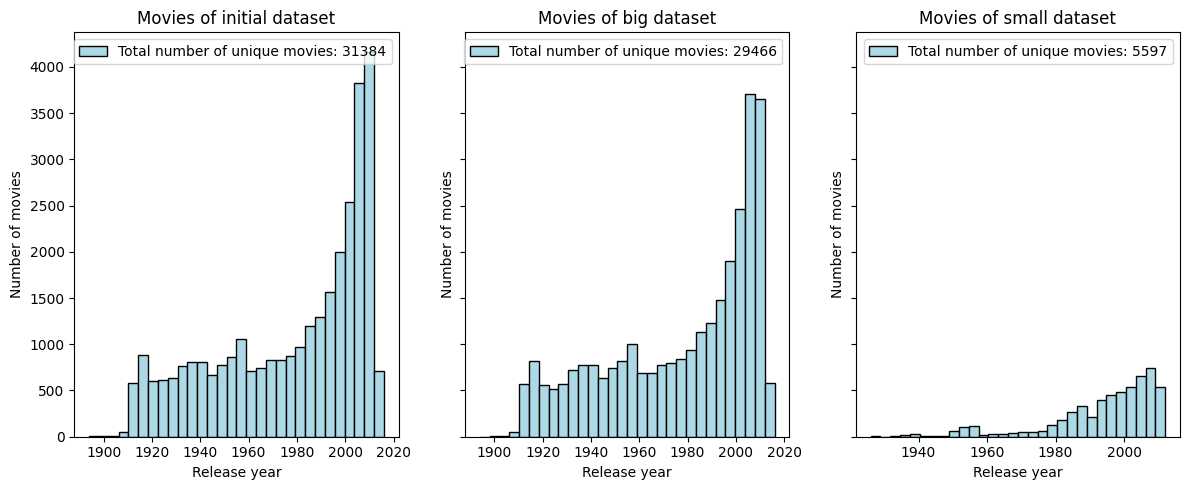

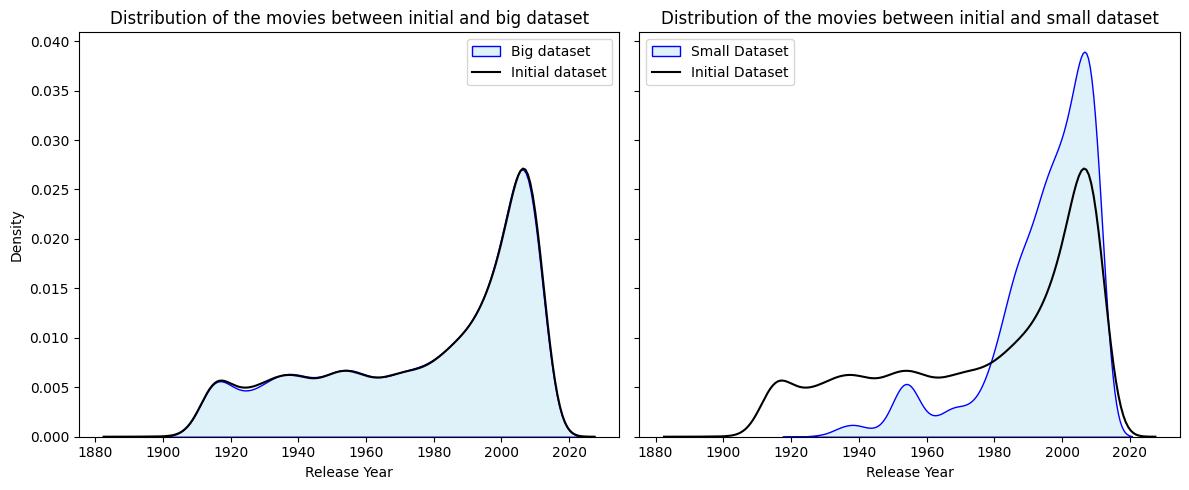

In [90]:
#count the number of unique movie containing the value of the subdataset  
merged_df_movies = merged_df.dropna(subset=['Movie_release_date']).drop_duplicates(subset='Movie_name')
big_df_movies = big_df.drop_duplicates(subset='Movie_name') 
small_df_movies = small_df.drop_duplicates(subset='Movie_name')
 
subdatasets = [(merged_df_movies, "Movies of initial dataset", len(merged_df_movies)), 
               (big_df_movies, "Movies of big dataset", len(big_df_movies)),
               (small_df_movies, 'Movies of small dataset', len(small_df_movies))] 
 
#graph for the different number of movies per subdataset 
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True) 
for ax, (data, title, n) in zip(axes.flatten(), subdatasets): 
    ax.hist(data['Movie_release_date'], bins=30, color='lightblue', edgecolor='black', label=f'Total number of unique movies: {n}') 
    ax.set_title(title) 
    ax.set_xlabel("Release year") 
    ax.set_ylabel("Number of movies") 
    ax.legend() 
plt.tight_layout() 
plt.show() 

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.kdeplot(big_df_movies['Movie_release_date'].dropna(),fill=True,color='skyblue',edgecolor='blue', label="Big dataset", ax=axes[0]) 
sns.kdeplot(merged_df_movies['Movie_release_date'].dropna(),color='black', label="Initial dataset", ax=axes[0]) 
axes[0].set_title("Distribution of the movies between initial and big dataset")
axes[0].set_xlabel("Release Year")
axes[0].set_ylabel("Density")
axes[0].legend()

sns.kdeplot(small_df_movies['Movie_release_date'].dropna(),fill=True,color='skyblue',edgecolor='blue',label="Small Dataset",ax=axes[1])
sns.kdeplot(merged_df_movies['Movie_release_date'].dropna(),color='black',label="Initial Dataset",ax=axes[1])
axes[1].set_title("Distribution of the movies between initial and small dataset")
axes[1].set_xlabel("Release Year")
axes[1].legend()

plt.tight_layout()
plt.show()


This plot shows the distribution of the movies along time.
For the big subdataset, we can observe that cleaning the dataset doesn't loose much data, and so our new dataset is still representatif of the initial data. And this is quite logical, as the moment when we lose a lot of data, is when we remove the movies without release date. But what shows the graph above is that all the other treatement we did on the data doesn't impact them.

For the other dataset (small), we can observe than the movies tends to be more recent on average, and that there is pretty much no movie before 1950, implying that we cannot necessary compare both subdatasets since they don't represent the same period of history.

# 5.First plots

## 5.1 Analysis on the "big" dataset

### 5.1.1 Gender proportion over time

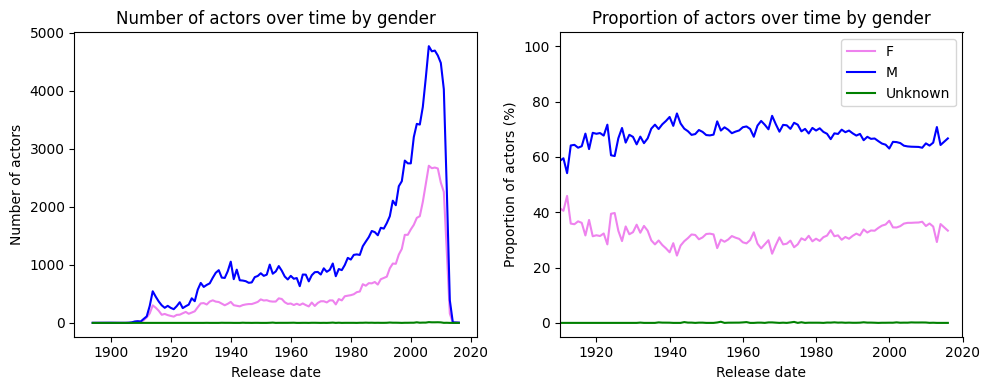

In [91]:
datafirstplot = big_df.groupby(["Movie_release_date","Actor_gender"]).Movie_release_date.count()
datafirstplot = pd.crosstab(big_df['Movie_release_date'],big_df['Actor_gender'])
datafirstplot_proportion = datafirstplot.div(datafirstplot.sum(axis=1), axis=0) * 100
colors=['violet', 'blue', 'green']
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
for i, column in enumerate(datafirstplot.columns):
    ax1.plot(datafirstplot.index, datafirstplot[column], label=column, color =colors[i])
    ax2.plot(datafirstplot_proportion.index, datafirstplot_proportion[column], label=column,color=colors[i])
    
ax1.set_xlabel("Release date")
ax1.set_ylabel("Number of actors")
ax1.set_title("Number of actors over time by gender")
ax2.set_xlabel("Release date")
ax2.set_xlim(1910, 2020)
ax2.set_ylabel("Proportion of actors (%)")
ax2.set_title("Proportion of actors over time by gender")

plt.tight_layout()
plt.legend()
plt.show()

### 5.1.2 Gender ages

C:\Users\locar\AppData\Local\Temp\ipykernel_26516\184867422.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=big_df["Actor_gender"], y=big_df["Actor_age_at_movie_release"], data=big_df,color='skyblue', palette=colors_boxplot)


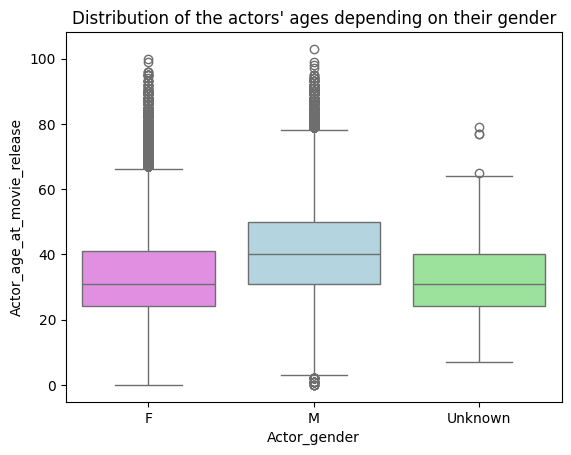

In [92]:
colors_boxplot = {'M': 'lightblue', 'F': 'violet', 'Unknown': 'lightgreen'}

sns.boxplot(x=big_df["Actor_gender"], y=big_df["Actor_age_at_movie_release"], data=big_df,color='skyblue', palette=colors_boxplot)
plt.title("Distribution of the actors' ages depending on their gender")
plt.show()

We can observe that the female actors seems to be younger that the males.

## 5.4 Analysis on the "small" dataset

In [93]:
a = small_df.groupby('Movie_name')['Movie_name'].count()
a.describe()

count    5597.000000
mean        4.262105
std         3.004776
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        28.000000
Name: Movie_name, dtype: float64

There a 5597 different movies therefore the sample is suficient

In [94]:
small_df.head(5)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country
1,Ghosts of Mars,2001.0,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.780,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America
2,Ghosts of Mars,2001.0,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",M,1.727,/m/0x67,Ice Cube,32.0,Thriller,United States of America
5,Ghosts of Mars,2001.0,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.727,/m/0x67,Pam Grier,52.0,Thriller,United States of America
51,Alexander's Ragtime Band,1938.0,3600000.0,106.0,[English],[United States of America],"[Musical, Comedy, Black-and-white]",M,1.820,/m/06v41q,Tyrone Power,24.0,Musical,United States of America
52,Alexander's Ragtime Band,1938.0,3600000.0,106.0,[English],[United States of America],"[Musical, Comedy, Black-and-white]",F,1.650,/m/033tf_,Alice Faye,23.0,Musical,United States of America


In [95]:
small_df.describe()

,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_height_m,Actor_age_at_movie_release
count,23855.000000,2.385500e+04,23855.000000,23855.000000,23855.000000
mean,1997.945085,1.002878e+08,109.712383,1.756703,38.572333
std,12.578370,1.829521e+08,25.293769,0.105173,13.825405
min,1925.000000,1.000000e+04,10.000000,0.813000,0.000000
25%,1993.000000,8.771516e+06,95.000000,1.680000,29.000000
50%,2001.000000,3.298088e+07,105.000000,1.760000,37.000000
75%,2007.000000,1.068777e+08,119.000000,1.830000,47.000000
max,2012.000000,2.782275e+09,1003.000000,2.200000,98.000000


We have a total of 5597 different movies therfore the sample is large enough. And we have a mean value of 4.26 character per film.


### 6.1.1 Gender ages

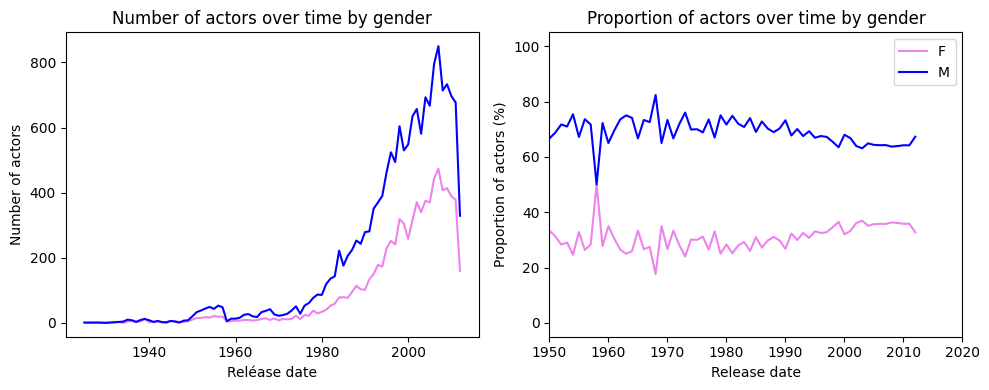

In [97]:
datafirstplot = small_df.groupby(["Movie_release_date","Actor_gender"]).Movie_release_date.count()
datafirstplot = pd.crosstab(small_df['Movie_release_date'],small_df['Actor_gender'])
datafirstplot_proportion = datafirstplot.div(datafirstplot.sum(axis=1), axis=0) * 100
color=['violet', 'blue']
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
for i, column in enumerate(datafirstplot.columns):
    ax1.plot(datafirstplot.index, datafirstplot[column], label=column, color = colors[i])
    ax2.plot(datafirstplot_proportion.index, datafirstplot_proportion[column], label=column, color = colors[i])
    
ax1.set_xlabel("Reléase date")
ax1.set_ylabel("Number of actors")
ax1.set_title("Number of actors over time by gender")
ax2.set_xlabel("Release date")
ax2.set_xlim(1950, 2020)
ax2.set_ylabel("Proportion of actors (%)")
ax2.set_title("Proportion of actors over time by gender")

plt.tight_layout()
plt.legend()
plt.show()

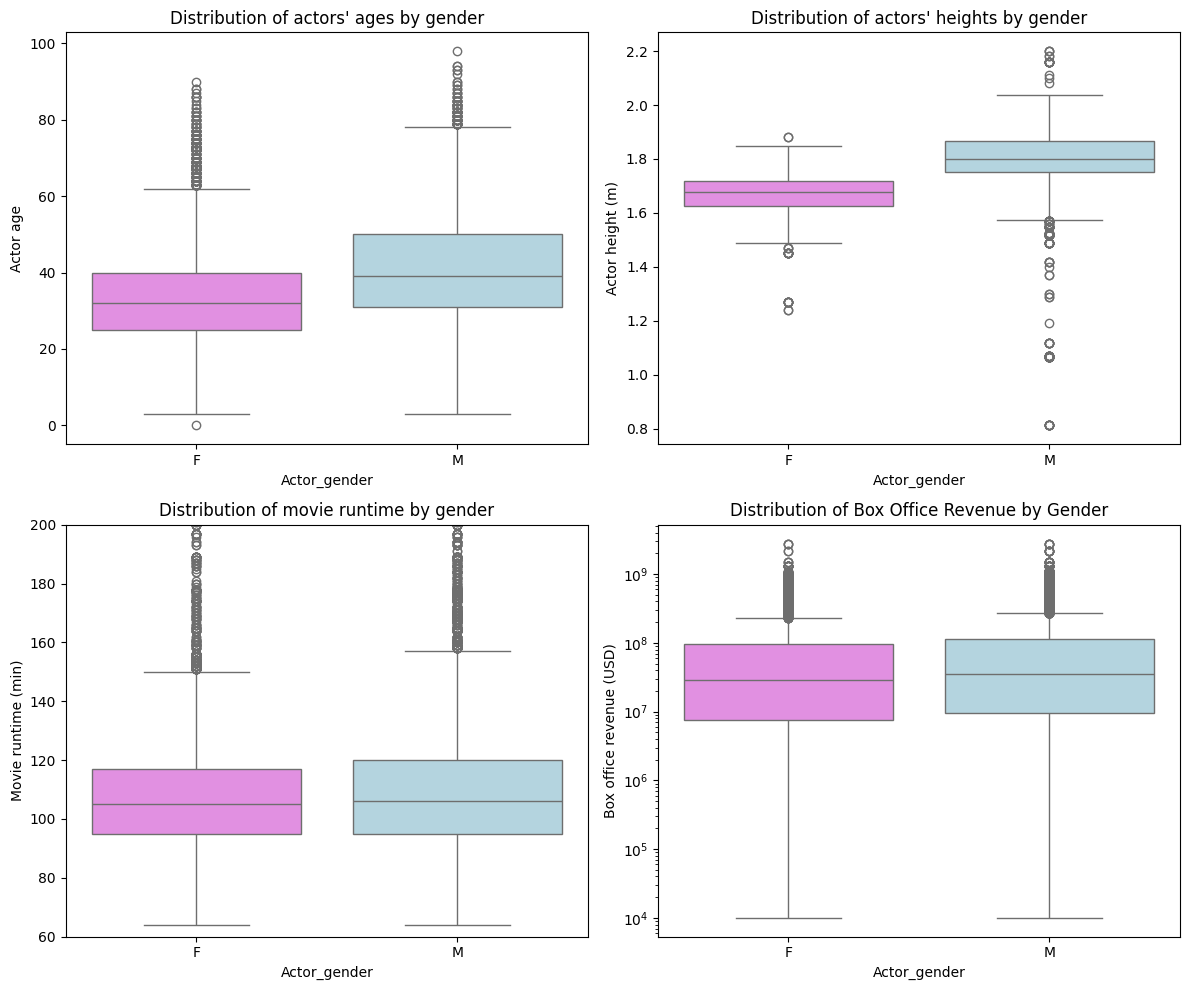

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x=small_df["Actor_gender"],y=small_df["Actor_age_at_movie_release"],data=small_df,hue="Actor_gender",palette=colors_boxplot,ax=axes[0, 0])
axes[0, 0].set_title("Distribution of actors' ages by gender")
axes[0, 0].set_ylabel("Actor age")

sns.boxplot(x=small_df["Actor_gender"],y=small_df["Actor_height_m"],data=small_df,hue="Actor_gender",palette=colors_boxplot,ax=axes[0, 1])
axes[0, 1].set_title("Distribution of actors' heights by gender")
axes[0, 1].set_ylabel("Actor height (m)")

sns.boxplot(x=small_df["Actor_gender"],y=small_df["Movie_runtime"],data=small_df,hue="Actor_gender",palette=colors_boxplot,ax=axes[1, 0])
axes[1, 0].set_title("Distribution of movie runtime by gender")
axes[1, 0].set_ylabel("Movie runtime (min)")
axes[1, 0].set_ylim(60, 200)

sns.boxplot(x=small_df["Actor_gender"],y=small_df["Movie_box_office_revenue"],data=small_df,hue="Actor_gender",palette=colors_boxplot,ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Box Office Revenue by Gender")
axes[1, 1].set_ylabel("Box office revenue (USD) (log)")
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


- We can see that woman are younger than men, it probably reflects something and could induce a bias.

- Porportion of woman and men seems to be more or less constant more test and analysis should be done to understand the evolution

- Men are taller (which is statically normal because men are bigger in life) but it could induce a bias for example if some movies requier tall actors.

- Men seems to play in longer movies that also could induces a bias.

The mean box office revenue is bigger for men actors than women this als could induces a bias


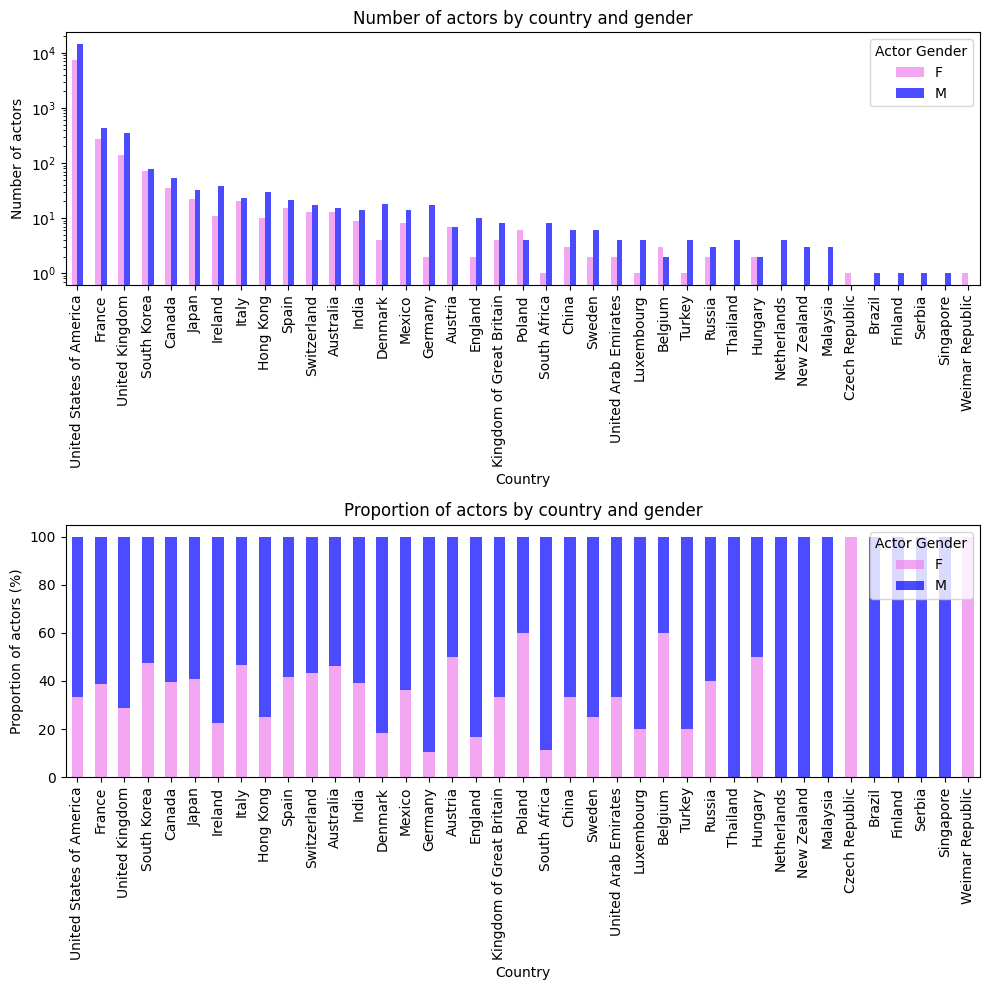

In [ ]:
datafirstplot = pd.crosstab(small_df['Main_country'], small_df['Actor_gender'])
datafirstplot['Total'] = datafirstplot.sum(axis=1)  # Add a Total column for sorting
datafirstplot = datafirstplot.sort_values('Total', ascending=False).drop(columns='Total')

datafirstplot_proportion = datafirstplot.div(datafirstplot.sum(axis=1), axis=0) * 100


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

datafirstplot.plot(kind='bar', stacked=False, ax=ax1, color=['violet', 'blue'], alpha=0.7)
ax1.set_xlabel("Country")
ax1.set_ylabel("Number of actors")
ax1.set_title("Number of actors by country and gender")
ax1.set_yscale('log')
ax1.legend(title="Actor Gender")


datafirstplot_proportion.plot(kind='bar', stacked=True, ax=ax2, color=['violet', 'blue'], alpha=0.7)
ax2.set_xlabel("Country")
ax2.set_ylabel("Proportion of actors (%)")
ax2.set_title("Proportion of actors by country and gender")
ax2.legend(title="Actor Gender")

plt.tight_layout()
plt.show()

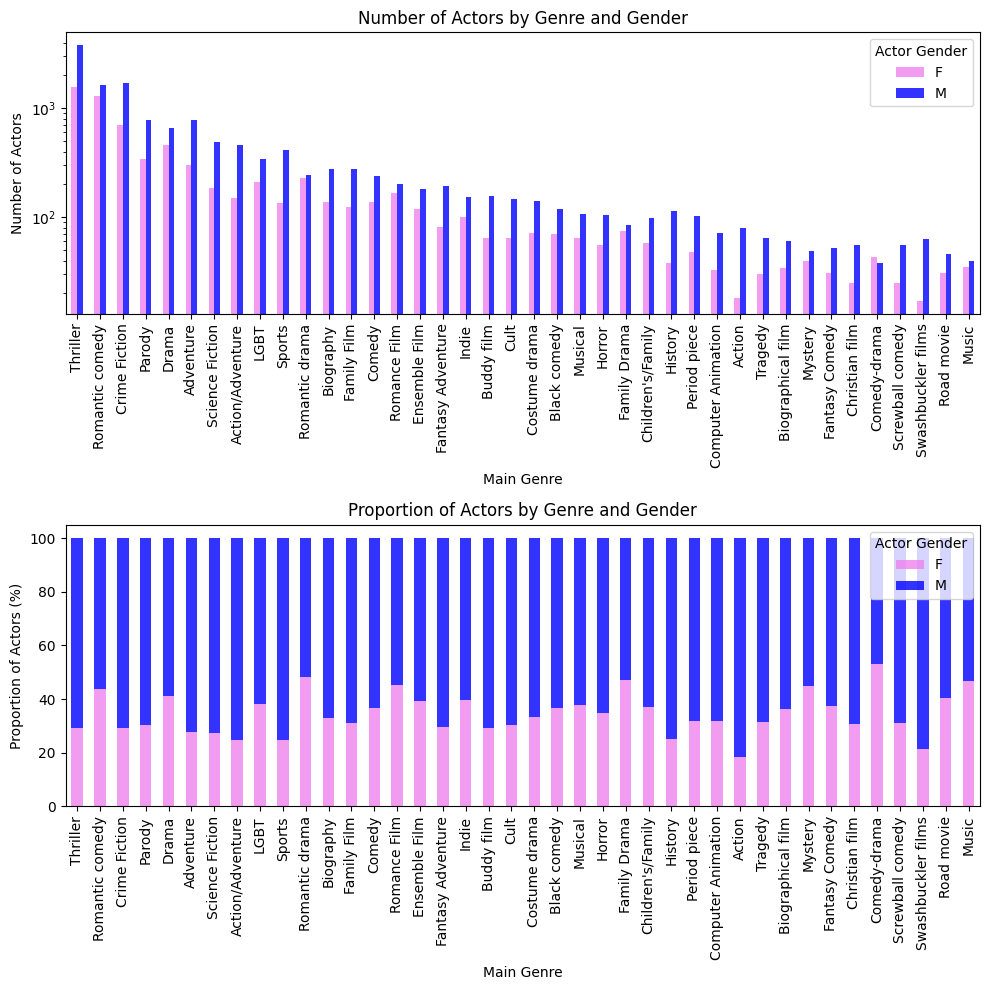

In [52]:

datafirstplot_genre = pd.crosstab(small_df['Main_genre'], small_df['Actor_gender'])

top_40_genres = datafirstplot_genre.sum(axis=1).nlargest(40).index
datafirstplot_genre_top_40 = datafirstplot_genre.loc[top_40_genres]

datafirstplot_proportion_genre = datafirstplot_genre_top_40.div(datafirstplot_genre_top_40.sum(axis=1), axis=0) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

datafirstplot_genre_top_40.plot(kind='bar', stacked=False, ax=ax1, color=['violet', 'blue'], alpha=0.8)
ax1.set_xlabel("Main Genre")
ax1.set_ylabel("Number of Actors")
ax1.set_title("Number of Actors by Genre and Gender")
ax1.set_yscale('log')
ax1.legend(title="Actor Gender")

datafirstplot_proportion_genre.plot(kind='bar', stacked=True, ax=ax2, color=['violet', 'blue'], alpha=0.8)
ax2.set_xlabel("Main Genre")
ax2.set_ylabel("Proportion of Actors (%)")
ax2.set_title("Proportion of Actors by Genre and Gender")
ax2.legend(title="Actor Gender")

plt.tight_layout()
plt.show()

Some genre are proiminent and the distribution is not the same for all movie genres

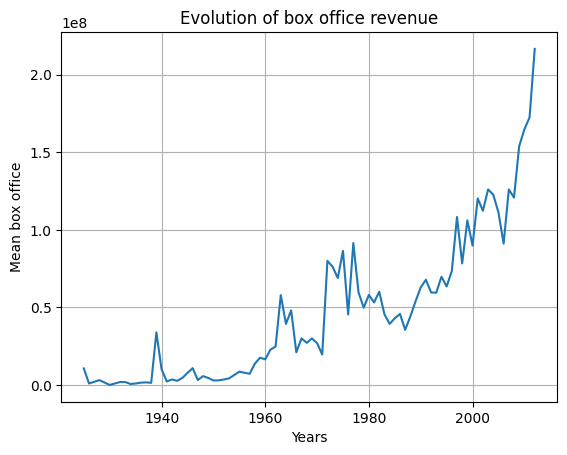

In [ ]:
data = small_df.groupby("Movie_release_date").Movie_box_office_revenue.mean().reset_index()
plt.plot(data.Movie_release_date, data.Movie_box_office_revenue)
plt.title('Evolution of box office revenue')
plt.xlabel('Release date')
plt.ylabel('Mean box office (USD)')
plt.grid()
plt.show()



Box office is bigger in time this also could induces a bias for example if box office increase in time (due to developpement of cinema industry) and mentalities also change, there would be a positive correlation with box office and genre repartition.

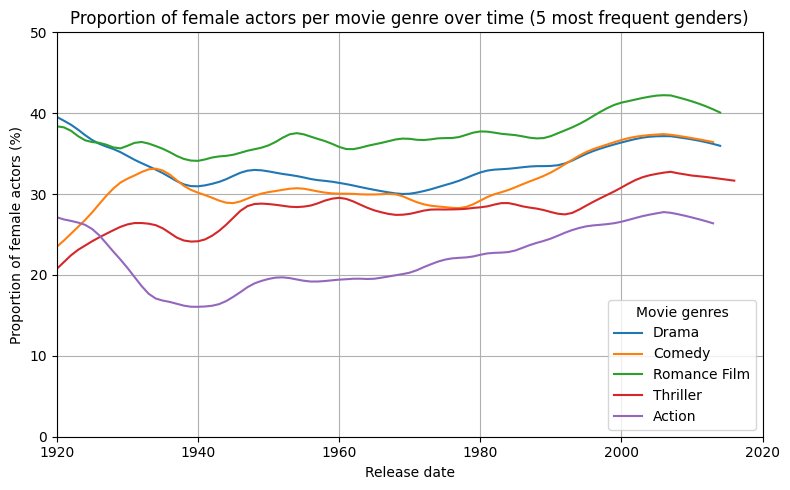

In [62]:
import statsmodels.api as sm

big_df_genres = big_df.explode('Movie_genres') #separate lines by movie genre
genre_counts = big_df_genres['Movie_genres'].value_counts()


nb_top = 5
top_X_genres = genre_counts.head(nb_top).index
#top_X_genres = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'Crime Fiction', 'Adventure', 'Horror', 'Fantasy']

cmap = plt.get_cmap('tab10', nb_top)
#colors = [cmap(i) for i in range(nb_top)]

big_df_top_genres = big_df_genres[big_df_genres['Movie_genres'].isin(top_X_genres)]

gender_per_genre = big_df_top_genres.groupby(["Movie_release_date", "Movie_genres", "Actor_gender"]).size().unstack(fill_value=0)
gender_per_genre['Female_Proportion'] = gender_per_genre['F']/gender_per_genre.sum(axis=1)*100

plt.figure(figsize=(8,5))
for i, genre in enumerate(top_X_genres):
    genre_data = gender_per_genre.xs(genre, level='Movie_genres')
    #plt.plot(genre_data.index, genre_data['Female_Proportion'], alpha = 0.25)
    smoothed = sm.nonparametric.lowess(genre_data['Female_Proportion'], genre_data.index, frac=0.15)
    plt.plot(smoothed[:,0], smoothed[:, 1], label=f'{genre}')

plt.xlabel("Release date")
plt.ylabel("Proportion of female actors (%)")
plt.title(f"Proportion of female actors per movie genre over time ({nb_top} most frequent genders)")
plt.xlim(1920,2020)
plt.ylim(0, 50)
plt.legend(title="Movie genres")
plt.grid()
plt.tight_layout()
plt.show()


The plot highlights the five most common movie genres and illustrates the proportion of female actors over time. It reveals a subtle trend of increasing female representation in recent years. Notably, the Action genre has experienced a more significant rise in the proportion of female actors compared to genres like Romance, where women have consistently held a higher representation. This will be explored more deeply in the final project's question #1.